In [115]:
#
# Chapter 10, Example 2a: multiplicative noise
#

import os
import pylab
import numpy as np
import tensorflow as tf
from tensorflow.keras import Model, layers, models, losses

if not os.path.isdir('figures'):
    print('creating the figures folder')
    os.makedirs('figures')

In [116]:
# Load and prepare the MNIST dataset. 
mnist = tf.keras.datasets.mnist
(x_train, _), (x_test, _) = mnist.load_data()
# Normalize image to [0,1]
x_train, x_test = x_train / 255.0, x_test / 255.0
print(x_train.shape)
print(x_test.shape)

(60000, 28, 28)
(10000, 28, 28)


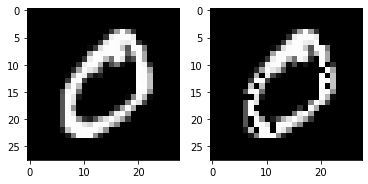

In [117]:
# Add multiplicative noise with binomial distribution, Corruption level 1 − p = 10%
noise_prob = 0.1
seed = 10
np.random.seed(seed)
train_noise = np.random.binomial(1, 1-noise_prob, x_train.shape)
x_train_noisy = x_train*train_noise
test_noise = np.random.binomial(1, 1-noise_prob, x_test.shape)
x_test_noisy = x_test*test_noise
# show an example: Original data and Corrupted data
pylab.figure()
pylab.gray()
pylab.axis('off')
pylab.subplot(1, 2, 1); pylab.imshow(x_train[1,:,:])
pylab.subplot(1, 2, 2); pylab.imshow(x_train_noisy[1,:,:])

In [118]:
# Built Model
tf.random.set_seed(seed)
tf.keras.backend.set_floatx('float32')
class Autoencoder(Model):
    def __init__(self, n_input, n_hidden):
        super(Autoencoder, self).__init__()
        # Initialize the weights and biases
        self.W = tf.Variable(tf.keras.backend.truncated_normal([n_input, n_hidden], stddev=1/np.sqrt(n_input)))
        self.b = tf.Variable(tf.zeros([n_hidden]))
        self.b_prime = tf.Variable(tf.zeros([n_input]))

    def call(self, x):
        h = tf.sigmoid(tf.matmul(x, self.W) + self.b)
        y = tf.sigmoid(tf.matmul(h, tf.transpose(self.W)) + self.b_prime)
        return y

autoencoder = Autoencoder(n_input=28*28,n_hidden=500)

In [119]:
# Set an optimizer and loss function for training
optimizer = tf.optimizers.SGD(learning_rate=0.1)
def loss(y,original):
    entropy_loss = - tf.reduce_mean(tf.reduce_sum(original * tf.math.log(y) + (1. - original) * tf.math.log(1. - y), axis=1))
    return entropy_loss

In [120]:
# Training function
def train(noisy,original):
    with tf.GradientTape() as tape:
        y = autoencoder(noisy)
        losses = loss(y, original)
        trainable_variables = [autoencoder.W,autoencoder.b,autoencoder.b_prime]
        gradients = tape.gradient(losses, trainable_variables)
        gradient_variables = zip(gradients, trainable_variables)
        optimizer.apply_gradients(gradient_variables)
    return losses

In [121]:
# Vectorize iamges 
x_test = tf.cast(x_test.reshape(x_test.shape[0],28*28), tf.float32)
x_train = tf.cast(x_train.reshape(x_train.shape[0],28*28), tf.float32)
x_test_noisy = tf.cast(x_test_noisy.reshape(x_test_noisy.shape[0],28*28), tf.float32)
x_train_noisy = tf.cast(x_train_noisy.reshape(x_train_noisy.shape[0],28*28), tf.float32)
# Use tf.data to batch and shuffle the train dataset
batch_size = 128
train_ds = tf.data.Dataset.from_tensor_slices((x_train_noisy,x_train)).shuffle(10000).batch(batch_size)

In [122]:
# Main function: train the model
no_epochs = 50
print('Training starts...')
l = [] 
for i in range(no_epochs):
    l_ = []
    for noisy, original in train_ds:
        l_.append(train(noisy,original))
    l.append(np.mean(l_))
    if i%1 == 0:
        print('epoch: %d, loss: %f'%(i, l[i]))

Training starts...
epoch: 0, loss: 99.637329
epoch: 1, loss: 73.069244
epoch: 2, loss: 67.903664
epoch: 3, loss: 65.435471
epoch: 4, loss: 63.987518
epoch: 5, loss: 63.018379
epoch: 6, loss: 62.303795
epoch: 7, loss: 61.749809
epoch: 8, loss: 61.296841
epoch: 9, loss: 60.918587
epoch: 10, loss: 60.592293
epoch: 11, loss: 60.303951
epoch: 12, loss: 60.051270
epoch: 13, loss: 59.819786
epoch: 14, loss: 59.616322
epoch: 15, loss: 59.423126
epoch: 16, loss: 59.248402
epoch: 17, loss: 59.084812
epoch: 18, loss: 58.936451
epoch: 19, loss: 58.796776
epoch: 20, loss: 58.662956
epoch: 21, loss: 58.539772
epoch: 22, loss: 58.426422
epoch: 23, loss: 58.320637
epoch: 24, loss: 58.217060
epoch: 25, loss: 58.120945
epoch: 26, loss: 58.028992
epoch: 27, loss: 57.942856
epoch: 28, loss: 57.859455
epoch: 29, loss: 57.781693
epoch: 30, loss: 57.710606
epoch: 31, loss: 57.639210
epoch: 32, loss: 57.566940
epoch: 33, loss: 57.505787
epoch: 34, loss: 57.444321
epoch: 35, loss: 57.384487
epoch: 36, loss: 57

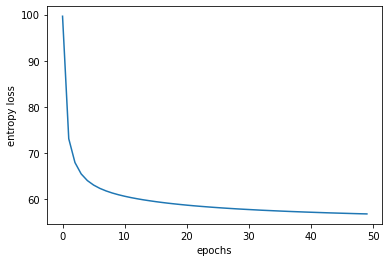

In [123]:
# Plot the loss curve
pylab.figure()
pylab.plot(range(no_epochs), l)
pylab.xlabel('epochs')
pylab.ylabel('entropy loss')
pylab.savefig('./figures/10.2a_1.png')

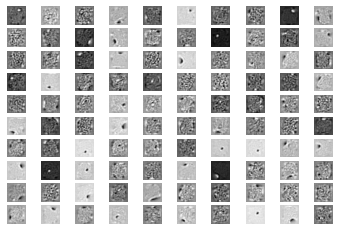

In [124]:
# Show the weights of autoencoder
pylab.figure()
pylab.gray()
for i in range(100):
    pylab.subplot(10, 10, i+1); pylab.axis('off'); pylab.imshow(np.array(autoencoder.W[:,i]).reshape(28,28))
pylab.savefig('./figures/10.2a_2.png')

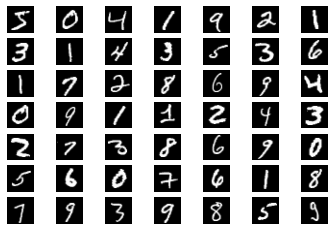

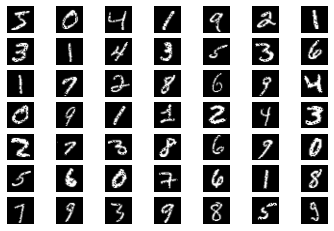

In [125]:
# Show Original data
pylab.figure()
pylab.gray()
for i in range(49):
    pylab.subplot(7, 7, i+1); pylab.axis('off'); pylab.imshow(np.array(x_train[i,:]).reshape(28,28))
pylab.savefig('./figures/10.2a_3.png')

# Show Corrupted data
pylab.figure()
pylab.gray()
for i in range(49):
    pylab.subplot(7, 7, i+1); pylab.axis('off'); pylab.imshow(np.array(x_train_noisy[i,:]).reshape(28,28))
pylab.savefig('./figures/10.2a_4.png')

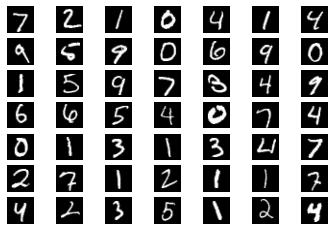

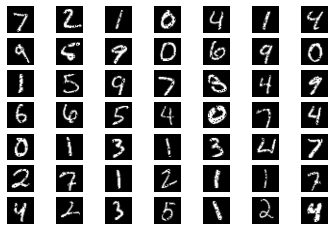

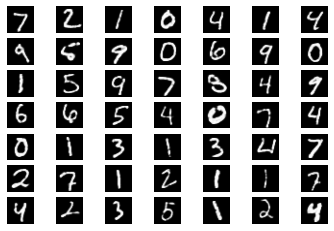

In [126]:
# Show original test data
pylab.figure()
pylab.gray()
for i in range(49):
    pylab.subplot(7, 7, i+1); pylab.axis('off'); pylab.imshow(np.array(x_test[i,:]).reshape(28,28))
pylab.savefig('./figures/10.2a_5.png')

# Show Corrupted test data
pylab.figure()
pylab.gray()
for i in range(49):
    pylab.subplot(7, 7, i+1); pylab.axis('off'); pylab.imshow(np.array(x_test_noisy[i,:]).reshape(28,28))
pylab.savefig('./figures/10.2a_6.png')

# Show reconstructed (noise-filtered) dat
x_test_out = autoencoder(tf.cast(x_test_noisy, tf.float32))
pylab.figure()
pylab.gray()
for i in range(49):
    pylab.subplot(7, 7, i+1); pylab.axis('off'); pylab.imshow(np.array(x_test_out[i,:]).reshape(28,28))
pylab.savefig('./figures/10.2a_7.png')